## Gensim in Py for topic modeling

We've seen latent topic models (LTMs) and their most popular implementation - the latent Dirichlet Allocation (LDA) - in R previously via the 'topicmodels' package. Py implements LDA as well - mostly thru either scikit-learn or gensim. 

Here's code for the gensim LDA implementation which will walk you through basic text-cleaning type preprocessing, tokenization and DTM building in BOW, some gensim specific data structures like dictionaries etc and finally LDA run and results.

Recall our conceptual buildup of LTMs. We viewed them as ways to factorize the DTM. To make gensim's workflow at least somewhat familiar and comparable to what we'd seen earlier, I'll try to output the topic factor score and loadings matrices as panda dataframes.

In [1]:
# setup chunk. Use pip or anaconda installer for following modules as appropriate

import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#### Step 1 - Read input text file(s)

Below I read in a file containing some 200 amazon.com reviews for samsung s7. Also provided are some other sample corpora to try the gensim code below on.

In [2]:
# read in file from local disk
path1 = 'C:\\Users\\31172\\TABA\\Session 3\\Session 3 Materials\\'
filename1 = 'samsung s7 reviews amazon.com.txt' # 'Game of Thrones IMDB reviews.txt'  # 'ISB PGP.txt'
corpus0 = open(path1 + filename1).readlines()  # corpus of stacked raw text documents

#### Step 2 - Preprocessing text

I define a simple func below 'textClean' to strip punctuations, html tags, pure numbers; tokenize and lemmatize to reduce token variety and dimensionality.

In [3]:
# import gensim.parsing.preprocessing
from gensim.parsing.preprocessing import strip_punctuation, strip_tags, strip_numeric
from nltk.stem.wordnet import WordNetLemmatizer   
from nltk.corpus import stopwords
import string  # for the .join() func

lemma = WordNetLemmatizer()

# NLTK Stop words extended
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def textClean(text0):
    text1 = [strip_punctuation(doc) for doc in text0]
    text1 = [strip_tags(doc) for doc in text1]
    text1 = [strip_numeric(doc) for doc in text1]
    text1 = [[" ".join([i for i in doc.lower().split() if i not in stop_words])] for doc in text1]
    text2 = [[word for word in ' '.join(doc).split()] for doc in text1]
    normalized = [[" ".join([lemma.lemmatize(word) for word in ' '.join(doc).split()])] for doc in text1]
    return normalized

corpus1 = textClean(corpus0)  # corpus cleaned of html tags, puncs, lemmas

#### Step 3 - DTM building in gensim

Below I demonstrate gensim's inbuilt n-gram builder *gensim.models.phrases.Phraser(ngram)*.

Note also the use of *corpora.Dictionary(tokenized-corpus)* to build a dictionary object in gensim.

Finally, the creation of a term frequency or TF based DTM using list comprehension. Here, *corpus* is the gensim corpus that can now directly be used in LDA running.

In [4]:
## DTM building etc via gensim
corpus2 = [[word for word in ' '.join(doc).split()] for doc in corpus1]  # word_tokenize first

# Building the bigram and trigram models
bigram = gensim.models.Phrases(corpus2, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[corpus2], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# print(trigram_mod[bigram_mod[corpus2[0]]])  # See trigram example

id2word = corpora.Dictionary(corpus2)  # Create Dictionary
corpus = [id2word.doc2bow(text) for text in corpus2]  # Building gensim corpus. TF DTM creation.
print(corpus[:1])  # View one doc in abstract form

[[(0, 3), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 4), (9, 1), (10, 1), (11, 1), (12, 1), (13, 5), (14, 1), (15, 6), (16, 1), (17, 2), (18, 1), (19, 1), (20, 2), (21, 1), (22, 1), (23, 1), (24, 2), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 3), (42, 4), (43, 1), (44, 2), (45, 1), (46, 1), (47, 2), (48, 1), (49, 1), (50, 2), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 3), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 5), (68, 1), (69, 2), (70, 1), (71, 1), (72, 1), (73, 3), (74, 1), (75, 1), (76, 4), (77, 2), (78, 2), (79, 1), (80, 1), (81, 1), (82, 2), (83, 1), (84, 2), (85, 1), (86, 1), (87, 1), (88, 1), (89, 4), (90, 1), (91, 2), (92, 3), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 5), (103, 5), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 2), (110, 1)

In [5]:
# Human readable format of corpus (term-frequency)
a0 = [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]
[x for (x, y) in a0[0] if y >4]

['app',
 'apps',
 'device',
 'galaxy',
 'get',
 'nexus',
 'phone',
 'samsung',
 'screen',
 'u',
 'version']

#### Step 4 - Running the LDA in gensim

Note use of *gensim.models.ldamodel.LdaModel()* to yield a LDAmodel object which we will further mine to get the topic factor matrices and other quantities of interest.

In [6]:
# Build LDA model for (say) K=4 topics
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

#### Step 5 - Obtain Factor Matrices

In parallel with what we'd done in R, we obtain from the gensim model object two factor matrices *beta* - which maps tokens to topics, and *gamma* - which maps docs to topics, as panda dataframes that can be exported to csv or R for further processing if required.

In keeping with good programming practice, I'm coding general funcs that can be called externally (e.g., from github) and used as required.

In [7]:
## def func for beta_df
import pandas as pd

## obtain the factor matrices - beta
def build_beta_df(lda_model=lda_model, id2word=id2word):
    beta = lda_model.get_topics()  # shape (num_topics, vocabulary_size).
    beta_df = pd.DataFrame(data=beta)

    # convert colnames in beta_df 2 tokens
    token2col = list(id2word.token2id)
    beta_df.columns = token2col
    # beta_df.loc[0,:].sum()  # checking if rows sum to 1

    # convert rownames too, eh? Using format(), .shape[] and range()
    rowNames=['topic' + format(x+1, '02d') for x in range(beta_df.shape[0])]
    rowNames_series = pd.Series(rowNames)
    beta_df.rename(index=rowNames_series, inplace=True)
    return(beta_df)

# invoke func
beta_df = build_beta_df(lda_model=lda_model, id2word=id2word)
beta_df.iloc[:8, :8]

,able,accessory,actual,actually,adapter,added,adjustment,ago
topic01,0.000601,0.000540,0.000046,0.001053,0.001760,0.000268,0.000047,0.000045
topic02,0.000626,0.000066,0.000634,0.000957,0.000119,0.000075,0.000260,0.000448
topic03,0.002680,0.000059,0.000442,0.001553,0.000057,0.000745,0.000055,0.001196
topic04,0.001255,0.000092,0.000393,0.000247,0.001941,0.000092,0.000092,0.000708


In [8]:
# func to get gamma matrix by looping using list.comp
def build_gamma_df(lda_model, corpus0):
    gamma_doc = []  # empty list 2 populate with gamma colms
    num_topics = lda_model.get_topics().shape[0]
    
    for doc in range(len(corpus0)):
        doc1 = corpus0[doc].split()
        bow_doc = id2word.doc2bow(doc1)
        gamma_doc0 = [0]*num_topics  # define list of zeroes num_topics long
        gamma_doc1 = lda_model.get_document_topics(bow_doc)
        gamma_doc2_x = [x for (x,y) in gamma_doc1]#; gamma_doc2_x
        gamma_doc2_y = [y for (x,y) in gamma_doc1]#; gamma_doc2_y
        for i in range(len(gamma_doc1)):
            x = gamma_doc2_x[i]
            y = gamma_doc2_y[i]
            gamma_doc0[x] = y  # wasn't geting this in list comprehension somehow 
        gamma_doc.append(gamma_doc0)
        
    gamma_df = pd.DataFrame(data=gamma_doc)  # shape=num_docs x num_topics
    topicNames=['topic' + format(x+1, '02d') for x in range(num_topics)]
    topicNames_series = pd.Series(topicNames)
    gamma_df.rename(columns=topicNames_series, inplace=True)
    return(gamma_df)

# now apply func
gamma_df = build_gamma_df(lda_model=lda_model, corpus0=corpus0)
gamma_df.iloc[:8, :]

,topic01,topic02,topic03,topic04
0,0.364816,0.479753,0.102905,0.052526
1,0.000000,0.000000,0.936671,0.062365
2,0.000000,0.000000,0.990882,0.000000
3,0.000000,0.965092,0.000000,0.034276
4,0.000000,0.000000,0.997250,0.000000
5,0.895379,0.000000,0.000000,0.094786
6,0.000000,0.000000,0.992738,0.000000
7,0.954646,0.033843,0.000000,0.010439


In [9]:
gamma_df.iloc[2,:].sum()  # check if the topic propns are ok

0.9908822774887085

#### Step 6 - Compute Fit metrics for topic models

I'm using two fit metrics that gensim readily outputs - theperplexity score 9we'd seen this in R as well) - lower the better; and the topic coherence score (higher the better).

After that, the plan is to detect the optimal number of topics to use by varying the num_topics, checking fit each time and finally, choosing the best fitting topic model. Recall that thi sis no different from what we did in choosing the optimal num_clusters in k-means, for example. 

See below.

In [10]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # model fit metric. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=corpus, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.211047838723843


C:\Users\31172\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:202: RuntimeWarning: invalid value encountered in true_divide
  numerator = (co_occur_count / num_docs) + EPSILON
C:\Users\31172\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:203: RuntimeWarning: invalid value encountered in true_divide
  denominator = (w_prime_count / num_docs) * (w_star_count / num_docs)
C:\Users\31172\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:198: RuntimeWarning: invalid value encountered in true_divide
  co_doc_prob = co_occur_count / num_docs



Coherence Score:  nan


Plan now is to put in place code for CV and calc of optimal # of topics.
Before that, perhaps some options to view and interpret key topics, key tokens in topics etc?

In [11]:
## compute coherence score (akin to LMD?)
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    num_topics1 = [i for i in range(start, limit, step)]
    for num_topics in num_topics1:
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=100,
                                           update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values  # note, list of 2 objs returned


In [12]:
# Can take a long time to run.
start1=2
limit1=19
step1=1

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, 
                                                        texts=corpus2, start=start1, limit=limit1, step=step1)

print(coherence_values)

[0.2951337657143259, 0.26170992409542826, 0.2965565651924838, 0.24627828311687336, 0.326060132440278, 0.3108777659957854, 0.3175909773442758, 0.3777023338697616, 0.40816834234042976, 0.38294354906548694, 0.36026077145974744, 0.3390160606719558, 0.3425865080763697, 0.39248692247211536, 0.39435631363939894, 0.37025994600826495, 0.44375202057181606]


In [13]:
# obtain optimal topic number
coher = list(enumerate(coherence_values))  # create an index for each list elem
index_max = [x for (x,y) in coher if y==max(coherence_values)]  # obtain index num corres to max coherence value
Optimal_numTopics = int(str(index_max[0]))+2  # convert that list elem into integer (int()) via string (str())
print(Optimal_numTopics)    

18


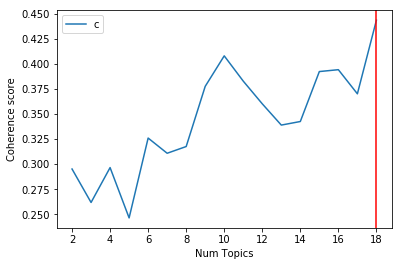

In [14]:
## Plot the change in coherence score with num_topics
import matplotlib.pyplot as plt
%matplotlib inline

start1=2
limit1=19
step1=1
# Show graph
x = range(start1, limit1, step1)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.axvline(x=Optimal_numTopics, color='r')
plt.show()

In [15]:
len(model_list)

17

In [16]:
## compute perplexity fit
def compute_perplexity_values(model_list, corpus, start, limit, step):
    """
    Compute c_v perplexity for various number of topics

    Parameters:
    ----------
    model list : LDA models list from coherence calc
    corpus : Gensim corpus
    start, limit, step
    

    Returns:
    -------
    model_list : List of LDA topic models
    perplexity_values : Perplexity fit metric for LDA model on a corpus. Lower the better.
    """
    perplexity_values = []
    for num_topics in range(start, limit, step):
        #model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=100,
        #                                  update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)
        model_index = num_topics - start
        model = model_list[model_index]
        perplexity_values.append(model.log_perplexity(corpus))
        #model_list.append(model)
        

    return perplexity_values  # note, list of 2 objs returned

# Can take a long time to run.
# perplexity_values = compute_perplexity_values(dictionary=id2word, corpus=corpus, start=2, limit=15, step=1)
perplexity_values = compute_perplexity_values(model_list, corpus=corpus, start=start1, limit=limit1, step=step1)
print(perplexity_values)

[-7.149284891082368, -7.1894304678786725, -7.2110476296150265, -7.23517506634476, -7.236846788389046, -7.248423428472603, -7.246192591368489, -7.204558658056754, -7.215230784704687, -7.238622010118542, -7.39075047641037, -7.477889231630469, -7.609850246948844, -7.667317091370378, -7.77034266312692, -7.742336159055632, -7.7948486569325395]


In [17]:
# compute optimal num_topics using perplexity based fit
perpl = list(enumerate(perplexity_values))  # create an index for each list elem
index_min = [x for (x,y) in perpl if y==min(perplexity_values)]  # obtain index num corres to max coherence value
optimal_numTopics = int(str(index_min[0]))+2  # convert that list elem into integer (int()) via string (str())
print(optimal_numTopics)  

18


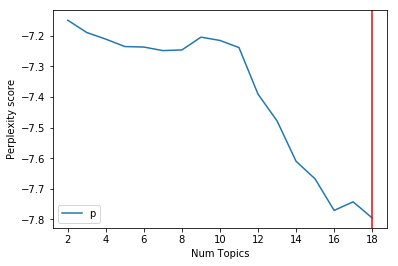

In [18]:
# graph the perplexity fit and see
import matplotlib.pyplot as plt
%matplotlib inline

# Show graph
x = range(start1, limit1, step1)
plt.plot(x, perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.axvline(x=optimal_numTopics, color='r')
plt.show()

In [21]:
# seems optimal num_topics is 10
optimal_model = model_list[10]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.034*"phone" + 0.017*"even" + 0.009*"item" + 0.009*"water" + 0.008*"work" '
  '+ 0.008*"video" + 0.008*"much" + 0.008*"pretty" + 0.008*"day" + '
  '0.008*"fast"'),
 (1,
  '0.013*"product" + 0.010*"march" + 0.007*"stripe" + 0.006*"unlocked" + '
  '0.006*"sensitive" + 0.005*"money" + 0.004*"small" + 0.004*"excelent" + '
  '0.003*"b" + 0.003*"sold"'),
 (2,
  '0.009*"shatter" + 0.009*"get" + 0.008*"great" + 0.007*"protect" + '
  '0.007*"terrible" + 0.007*"connection" + 0.007*"working" + 0.007*"buyer" + '
  '0.006*"screen" + 0.006*"drop"'),
 (3,
  '0.000*"phone" + 0.000*"edge" + 0.000*"one" + 0.000*"galaxy" + 0.000*"it’s" '
  '+ 0.000*"samsung" + 0.000*"time" + 0.000*"like" + 0.000*"screen" + '
  '0.000*"card"'),
 (4,
  '0.023*"phone" + 0.017*"battery" + 0.014*"case" + 0.014*"it’s" + '
  '0.011*"edge" + 0.009*"galaxy" + 0.008*"–" + 0.008*"good" + 0.007*"display" '
  '+ 0.007*"day"'),
 (5,
  '0.007*"received" + 0.007*"film" + 0.007*"feedback" + 0.006*"outlet" + '
  '0.006*"seal" + 0

#### Step 7 - explore topics obtained from optimal model

In what follows below, I try to build a dataframe of docs with their dominant topic, its main keywords and some text from the document.

In [22]:
# Get main topic in each document
gamma_df = build_gamma_df(lda_model=optimal_model, corpus0=corpus0)
#gamma_df.iloc[:8,:8]

row0 = gamma_df.values.tolist()
row=[]
for i in range(len(row0)):
    row1 = list(enumerate(row0[i]))
    row1_y = [y for (x,y) in row1]
    max_propn = sorted(row1_y, reverse=True)[0]
    row2 = [(i, x, y) for (x, y) in row1 if y==max_propn]
    row.append(row2)

row[0:7]

[[(0, 8, 0.9561975598335266)],
 [(1, 8, 0.7906836271286011)],
 [(2, 2, 0.9278461337089539)],
 [(3, 11, 0.9938839673995972)],
 [(4, 8, 0.979606032371521)],
 [(5, 8, 0.486307293176651)],
 [(6, 8, 0.6893921494483948)]]

In [23]:
sent_topics_df = pd.DataFrame()
for row1 in row:
    for (doc_num, topic_num, prop_topic) in row1:
        wp = optimal_model.show_topic(topic_num)
        topic_keywords = ", ".join([word for word, prop in wp])
        sent_topics_df = sent_topics_df.append(pd.Series([int(doc_num), int(topic_num), 
                                                          round(prop_topic,4), 
                                                          topic_keywords]), 
                                                       ignore_index=True)
    
sent_topics_df.columns = ['Doc_num', 'Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']    
sent_topics_df.iloc[:8, :]

,Doc_num,Dominant_Topic,Perc_Contribution,Topic_Keywords
0,0.0,8.0,0.9562,"phone, samsung, screen, edge, one, great, vers..."
1,1.0,8.0,0.7907,"phone, samsung, screen, edge, one, great, vers..."
2,2.0,2.0,0.9278,"shatter, get, great, protect, terrible, connec..."
3,3.0,11.0,0.9939,"x, phone, gb, year, mp, core, w, kg, ram, quad"
4,4.0,8.0,0.9796,"phone, samsung, screen, edge, one, great, vers..."
5,5.0,8.0,0.4863,"phone, samsung, screen, edge, one, great, vers..."
6,6.0,8.0,0.6894,"phone, samsung, screen, edge, one, great, vers..."
7,7.0,10.0,0.5897,"phone, g, battery, charge, day, good, one, say..."


In [24]:
# Add original text to the end of the output
contents = pd.Series(corpus0)
sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
#return(sent_topics_df)
sent_topics_df.columns = ['Doc_num', 'Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'contents']
sent_topics_df.iloc[:8,:]

,Doc_num,Dominant_Topic,Perc_Contribution,Topic_Keywords,contents
0,0.0,8.0,0.9562,"phone, samsung, screen, edge, one, great, vers...",I bought the Samsung Galaxy S7 Edge G935F in B...
1,1.0,8.0,0.7907,"phone, samsung, screen, edge, one, great, vers...",The Galaxy S7 Edge is a nice phone. There is n...
2,2.0,2.0,0.9278,"shatter, get, great, protect, terrible, connec...","Buyers Be AwareThis shipper has send me 'FAKE""..."
3,3.0,11.0,0.9939,"x, phone, gb, year, mp, core, w, kg, ram, quad","Oh, another year 2016. Another set of phones f..."
4,4.0,8.0,0.9796,"phone, samsung, screen, edge, one, great, vers...",The phone worked great. I bought it from Amazo...
5,5.0,8.0,0.4863,"phone, samsung, screen, edge, one, great, vers...",I ordered this phone which was branded as an o...
6,6.0,8.0,0.6894,"phone, samsung, screen, edge, one, great, vers...",Received the phone today. I carefully take a l...
7,7.0,10.0,0.5897,"phone, g, battery, charge, day, good, one, say...",After being a loyal Samsung/Galaxy customer fo...


Well, that's it for now from my side.

gensim has some impressive capabilities - like: 
1. working with streaming data 
2. the ability to save and load models on demand
3. the ability to extrapolate to new or previously unseen docs 
4. distributed processing capabilities
5. works well with the rest of the py ecosystem. E.g., can do nlp in spacy and LTM in gensim all in one workflow
6. etc.

Sudhir